In [1]:
from pathlib import Path
import json
import numpy as np
import h5py
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision import datasets, transforms
from dataloader import Custom3DShapesDataset,EfficientCustom3DShapesDataset
from model import CNNEncoder
from loss import BatchAllTtripletLoss
import pandas as pd
from main import train_loop
from utils import plot_samples_from_loader,create_animation
# set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('config.json') as json_file:
    config = json.load(json_file)
    data_folder = Path(config['dataset']['basepath'])

    fig_path =  Path(config['reporting']['figpath'])
    result_path = Path(config['reporting']['data'])
    model_path = Path(config['reporting']['model'])
    anim_path = Path(config['reporting']['animation'])

In [2]:
# Define data transformations (you can customize these)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training dataset
train_dataset = datasets.MNIST(root=data_folder/'data', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root=data_folder/'data', train=False, transform=transform, download=True)

# Create a DataLoader for the training dataset
batch_size = 64  # You can adjust this batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

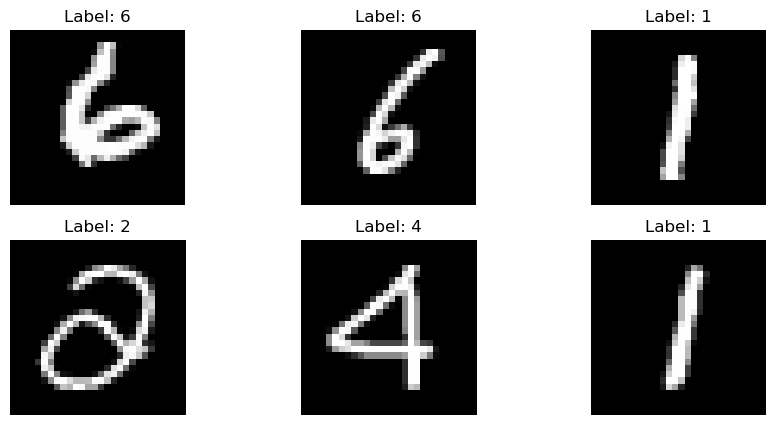

In [3]:
# Usage:
n_rows = 2  # Number of rows of subplots
n_cols = 3  # Number of columns of subplots
plot_samples_from_loader(val_loader, n_rows, n_cols)

In [4]:
# Example usage with ResNet-50 as the backbone and latent_dim=128
latent_dim = 32
resnet50_encoder = CNNEncoder(models.resnet50,latent_dim  = latent_dim, input_shape= 1).to(device)


# num_classes =  dataset._NUM_VALUES_PER_FACTOR['shape']
# resnet50_classifier = CNNClassifier(models.resnet50, num_classes).to(device)



criterion = BatchAllTtripletLoss() 
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_encoder.parameters(), lr=0.001)

# Train the model
num_epochs = 2  # You can adjust the number of epochs as needed
model,train_losses = train_loop(resnet50_encoder, train_loader, val_loader, criterion, optimizer, device, num_epochs)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/net/store/cv/users/ybrima/miniconda3/envs/subcon/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_18034/203821315.py", line 17, in <module>
    model,train_losses = train_loop(resnet50_encoder, train_loader, val_loader, criterion, optimizer, device, num_epochs)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/net/store/cv/users/ybrima/RTGCompCog/SubCon/main.py", line 66, in train_loop
    extract_and_visualize_embeddings(model, valloader, device, dim = None, counter = counter, class_labels = class_labels)
  File "/net/store/cv/users/ybrima/RTGCompCog/SubCon/utils.py", line 46, in extract_and_visualize_embeddings
  File "/net/store/cv/users/ybrima/miniconda3/envs/subcon/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py", line 1119, in fit_trans

In [4]:
# Create the animation of the training process
import os
animation_files =  Path(config['reporting']['animation'])

image_files = [ anim_path/f"tsne_embeddings_{i}.png" for i in range(len(os.listdir(animation_files)))]

output_filename = fig_path/"mnist_tripplet_animation.gif"

create_animation(image_files, output_filename, duration=300)  # Adjust the duration as needed